In [1]:
# Pooja Ganesh
# UIUC
# Task : Car Brand Prediction using multiclass classification with Finetuning on Pretrained Models.
# GPU Cloud : Runpod.io
# Data Source : Kaggle (exact link on git)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'cars_data_10'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

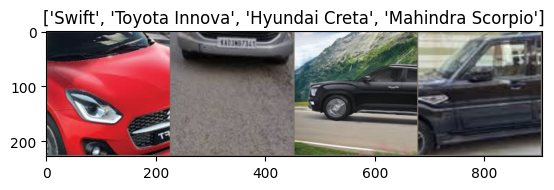

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                #ax.set_title(f'true: {class_names[labels[j]]}')
                print(f'true: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
!pip install torcheval

  Using cached torcheval-0.0.7-py3-none-any.whl.metadata (8.6 kB)
Using cached torcheval-0.0.7-py3-none-any.whl (179 kB)


In [7]:
import torch.nn.functional as F
import torch
from torcheval.metrics import MulticlassF1Score, MulticlassPrecision, MulticlassAccuracy

def evaluate_model(model, dataloader, criterion, num_classes=10, average="macro", k=2, criteria="exact_match"):

    model.eval()  # Set model to evaluation mode

    total_loss = 0  # Initialize to accumulate loss over all batches

    # Create metrics with appropriate averaging
    f1_metric = MulticlassF1Score(num_classes=num_classes, average=average)
    precision_metric = MulticlassPrecision(num_classes=num_classes, average=average)
    acc = MulticlassAccuracy(num_classes=num_classes, average=average)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # Calculate loss for the current batch
            batch_loss = criterion(outputs, labels).item()
            total_loss += batch_loss

            if torch.nn.functional.softmax(model(inputs), dim=-1).shape == outputs.shape:  # Ensure softmax alignment
                f1_metric.update(outputs, labels)
                precision_metric.update(outputs, labels)
                #labels_onehot = F.one_hot(labels, num_classes=num_classes)
                acc.update(outputs, labels)

    # Calculate average loss over all batches
    average_loss = total_loss / len(dataloader)

    # Compute multi-class metrics
    f1_score = f1_metric.compute()
    precision_score = precision_metric.compute()
    accuracy = acc.compute()

    return f1_score, precision_score, accuracy, average_loss



In [9]:
# Define your model with the desired architecture
model = models.googlenet(pretrained=False)

# Modify the last layer to match your desired output features
model.fc = nn.Linear(in_features=1024, out_features=10)

# Load the saved weights into your model, ignoring missing keys related to auxiliary classifiers
model_weights_path = "./model_weights_googlenet.pth"
state_dict = torch.load(model_weights_path, map_location=torch.device('cpu'))
model_dict = model.state_dict()

# Filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}

# Update the model's state dict
model_dict.update(state_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [10]:
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [11]:
test_data = dataloaders['test']

In [12]:
criterion = nn.CrossEntropyLoss()
f1_score,precision_score,accuracy,average_loss = evaluate_model(model, test_data, criterion)

c:\Users\Pooja\anaconda3\envs\venv\lib\site-packages\torcheval\metrics\functional\classification\accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:235.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


In [13]:
print("GoogleNet: ", f1_score,precision_score,accuracy,average_loss)

GoogleNet:  tensor(0.8158) tensor(0.8822) tensor(0.7958) 0.65573683067517


true: Swift


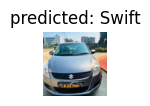

true: Tesla


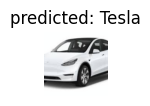

true: Tata Safari


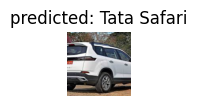

true: Mahindra Scorpio


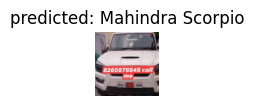

true: Mahindra Scorpio


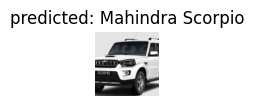

true: Tata Safari


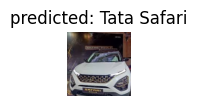

true: Porsche


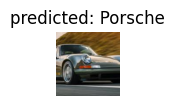

true: Hyundai Creta


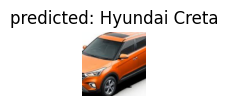

true: Mahindra Scorpio


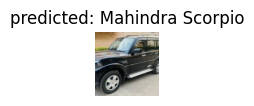

true: BMW


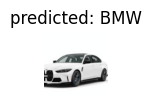

In [14]:
# Making prediction with the loaded weights model
visualize_model(model)